# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-10-12 19:29:05,784 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


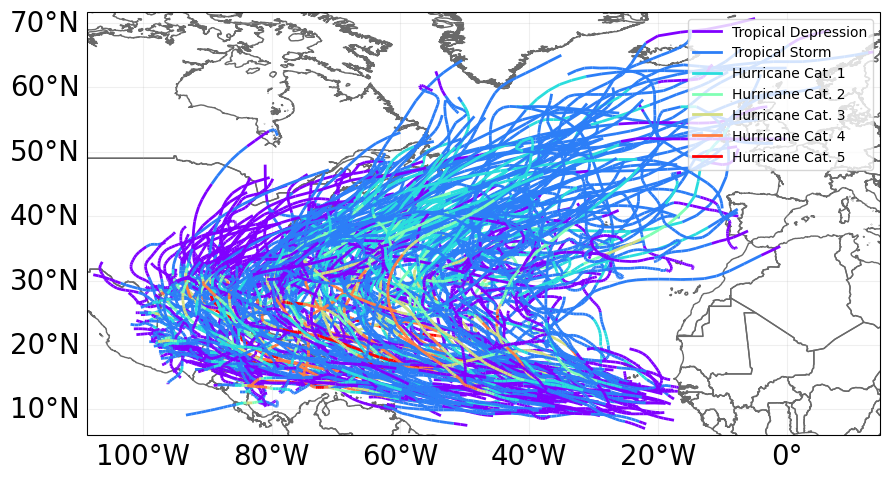

In [3]:
ax = tc_tracks.plot()

### Normalise data

In [4]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [5]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (8186, 42, 3): 8186 contexts of length 42 with 3 features each
Test contexts have shape (913, 42, 3): 913 contexts of length 42 with 3 features each


In [6]:
training_data_size = contexts["train"].shape[0]
training_data_size

8186

In [7]:
contexts["train"].shape

(8186, 42, 3)

In [8]:
contexts["train"][:12].shape

(12, 42, 3)

### Predict time series and plot in original coordinates

In [9]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 50.0


In [10]:
# model = Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi')
model = Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42)
# model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

In [11]:
contexts['train'].shape

(8186, 42, 3)

In [12]:
stop = 2500
model, fit_time = timer(model.fit)(contexts['train'][:stop])

(1, 42, 3)
(1, 13, 3)


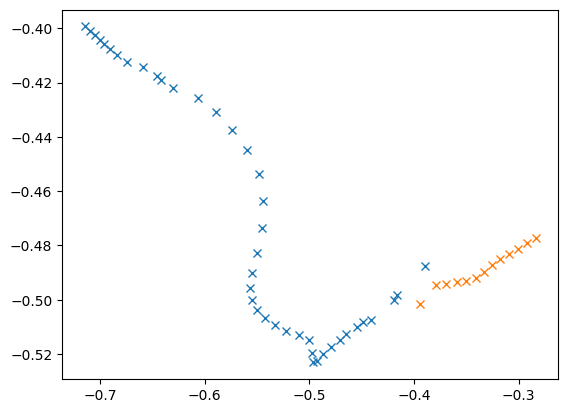

In [13]:
idx = np.random.randint(0, contexts["train"].shape[0])
initial_context = contexts['train'][idx]
print(initial_context.shape)
ts = predict_time_series(model, initial_context, n_steps=13)
print(ts.shape)
plt.plot(initial_context.data[0, :, 0], initial_context.data[0, :, 1], "x")
plt.plot(ts[0, :, 0], ts[0, :, 1], "x")

NOTE: Checkout from kooplearn._src.operator_regression.dual import predict

This function can predict for several time steps but only outputs the last one. Predicting a given context for several timesteps leads probably to something different than predicting one time step ahead, building the new context by shifting to this, and compute the next time step prediction and so on. Could be interesting to compare these two things in terms of runtime and accuracy. Predicting several time steps for given context without shift should be much faster, since only matrix multiplication needs to be applied iteratively. For this predict() needs to be slightly modified to also return intermediate results.

## Train and compare models

In [14]:
from klearn_tcyclone.models_utils import runner
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
eval_metric = RMSE_OneStep_TCTracks

In [15]:
# train_stops = np.logspace(1.5, 2.5, 3).astype(int)
train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([ 316,  707, 1584, 3548, 7943])

In [16]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

models = {
    # 'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
    'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

Length scale: 50.0


In [17]:
results = {}
for name in models.keys():
    results[name] = []
for ((name, model), stop) in product(models.items(), train_stops):
    print(f"\nModel: {name}", f'Training points: {stop}')
    results[name].append(runner(model, contexts, stop))


Model: Randomized-RRR Training points: 316

Model: Randomized-RRR Training points: 707

Model: Randomized-RRR Training points: 1584

Model: Randomized-RRR Training points: 3548

Model: Randomized-RRR Training points: 7943

Model: Nystroem-RRR Training points: 316


The rank attribute has been updated to 16.
Consider decreasing the rank parameter.



Model: Nystroem-RRR Training points: 707



Model: Nystroem-RRR Training points: 1584



Model: Nystroem-RRR Training points: 3548



Model: Nystroem-RRR Training points: 7943


In [18]:
for name in models.keys():
    for res in results[name]:
        res["RMSE_onestep_train_error"] = eval_metric(
            res["X_pred_train"], res["X_true_train"]
        )
        res["RMSE_onestep_test_error"] = eval_metric(
            res["X_pred_test"], res["X_true_test"]
        )

In [19]:
timings = {name: np.array([res["fit_time"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_train_errors = {name: np.array([res["RMSE_onestep_train_error"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_test_errors = {name: np.array([res["RMSE_onestep_test_error"] for res in results[name]]) for name in models.keys()}
speedup_train = {name: timings["Randomized-RRR"]/timings[name] for name in models.keys()}

Average fitting time speed-up for Randomized-RRR: 1.00x
Average fitting time speed-up for Nystroem-RRR: 5.92x


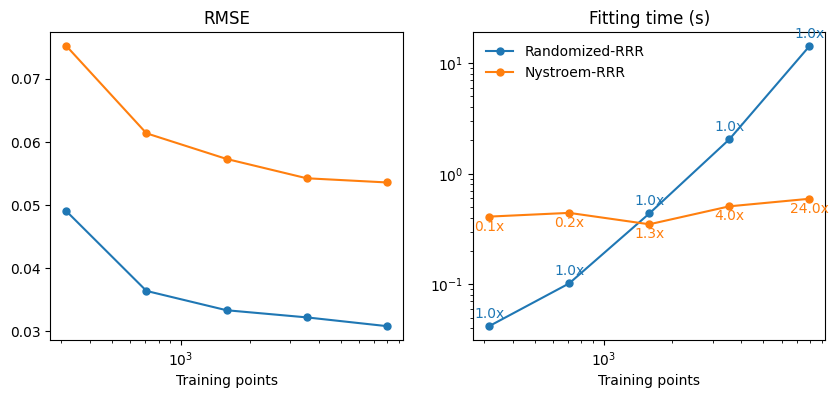

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, RMSE_onestep_train_errors[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup_train[name]):
        if (name == 'Randomized-RRR'):
            c = colors[0]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup_train[name]):.2f}x")



### ModelBenchmark class

The above functionality (and a bit more) is combined in the ModelBenchmark class.

In [21]:
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
eval_metric = RMSE_OneStep_TCTracks

In [22]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
context_length = 42
feature_list = ["lat", "lon"]
scaler = LinearScaler()


reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

models = {
    'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
    'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

2024-10-12 19:30:37,725 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393
Length scale: 50.0


In [23]:
# train_stops = np.logspace(2.5, 2.9, 5).astype(int)
train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([ 316,  707, 1584, 3548, 7943])

In [24]:
model_benchmarks = {
    name: ModelBenchmark(
        features=feature_list,
        tc_tracks_train=tc_tracks_train,
        tc_tracks_test=tc_tracks_test,
        scaler=scaler,
        context_length=context_length,
    )
    for name in models.keys()
}

In [25]:
print([mb.get_info() for mb in model_benchmarks.values()])

Train contexts have shape (8040, 42, 2): 8040 contexts of length 42 with 2 features each.
Test contexts have shape (1059, 42, 2): 1059 contexts of length 42 with 2 features each.
Train contexts have shape (8040, 42, 2): 8040 contexts of length 42 with 2 features each.
Test contexts have shape (1059, 42, 2): 1059 contexts of length 42 with 2 features each.
Train contexts have shape (8040, 42, 2): 8040 contexts of length 42 with 2 features each.
Test contexts have shape (1059, 42, 2): 1059 contexts of length 42 with 2 features each.
[None, None, None]


In [26]:
results = {
    name: mb.train_model(
        model=models[name],
        eval_metric=eval_metric,
        train_stops=train_stops,
    )
    for name, mb in model_benchmarks.items()
}


Model training: Training points: 316
Fitting of model took 0.04s with train RMSE of 0.02732 and test RMSE of 0.03005.

Model training: Training points: 707


Fitting of model took 0.11s with train RMSE of 0.02299 and test RMSE of 0.02524.

Model training: Training points: 1584


Fitting of model took 0.62s with train RMSE of 0.01995 and test RMSE of 0.02252.

Model training: Training points: 3548


Fitting of model took 3.68s with train RMSE of 0.01920 and test RMSE of 0.02123.

Model training: Training points: 7943


Fitting of model took 23.58s with train RMSE of 0.01932 and test RMSE of 0.02101.

Model training: Training points: 316
Fitting of model took 0.01s with train RMSE of 0.02732 and test RMSE of 0.03005.

Model training: Training points: 707
Fitting of model took 0.06s with train RMSE of 0.02299 and test RMSE of 0.02524.

Model training: Training points: 1584
Fitting of model took 0.27s with train RMSE of 0.01995 and test RMSE of 0.02252.

Model training: Training points: 3548
Fitting of model took 1.48s with train RMSE of 0.01920 and test RMSE of 0.02122.

Model training: Training points: 7943


The rank attribute has been updated to 11.
Consider decreasing the rank parameter.


Fitting of model took 9.12s with train RMSE of 0.01932 and test RMSE of 0.02101.

Model training: Training points: 316


The rank attribute has been updated to 10.
Consider decreasing the rank parameter.


Fitting of model took 0.11s with train RMSE of 0.05398 and test RMSE of 0.06073.

Model training: Training points: 707


Fitting of model took 0.16s with train RMSE of 0.04641 and test RMSE of 0.05103.

Model training: Training points: 1584
Fitting of model took 0.16s with train RMSE of 0.04117 and test RMSE of 0.04530.

Model training: Training points: 3548


Fitting of model took 0.24s with train RMSE of 0.04046 and test RMSE of 0.04303.

Model training: Training points: 7943


Fitting of model took 0.40s with train RMSE of 0.04197 and test RMSE of 0.04354.


Add RMSE to results dictionary.

In [27]:
for name in models.keys():
    for res in results[name]:
        res["RMSE_onestep_train_error"] = eval_metric(
            res["X_pred_train"], res["X_true_train"]
        )
        res["RMSE_onestep_test_error"] = eval_metric(
            res["X_pred_test"], res["X_true_test"]
        )

In [28]:
timings = {name: np.array([res["fit_time"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_train_errors = {name: np.array([res["RMSE_onestep_train_error"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_test_errors = {name: np.array([res["RMSE_onestep_test_error"] for res in results[name]]) for name in models.keys()}
speedup_train = {name: timings["RRR"]/timings[name] for name in models.keys()}
# speedup_train = {name: timings["Randomized-RRR"]/timings[name] for name in models.keys()}

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Randomized-RRR: 2.52x
Average fitting time speed-up for Nystroem-RRR: 15.69x


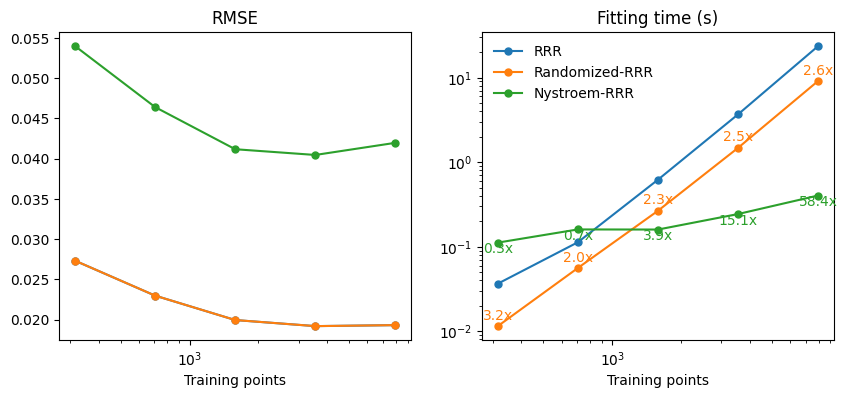

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, RMSE_onestep_train_errors[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup_train[name]):
        if (name == 'Randomized-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup_train[name]):.2f}x")

